In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
from scipy import spatial
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [26]:
def top_samples(source, target, num):
    temp_list = []
    for i in range(target.shape[0]):
        temp_list.append([spatial.distance.cosine(source, target[i]), i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, 5)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 1000/1000 [2:14:05<00:00,  8.05s/it] 


In [28]:
# with open(r"input_near_cos.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_cos.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [29]:
# with open(r"input_near_cos.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_cos.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [30]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [31]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [32]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [34]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [35]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

In [36]:
input_near = input_near.to(device)
output_near = output_near.to(device)

In [37]:
input_feature = RNA_s1d1.shape[1]

In [38]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [39]:
PATH = 'No_norm_model_RNA_pro'

In [40]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 2.034103 s1d1:  1.9873426 s1d2:  2.1560671 s1d3:  1.8872297 s2d1: 0.7501798 s2d4: 1.4132674 s2d5: 1.3354026 s3d1: 0.55109316 s3d6: 1.384806 s3d7: 1.5382569 s4d1: 1.7777919 s4d8: 2.115362 s4d9: 1.2492173 test loss: 1.6426155373829292


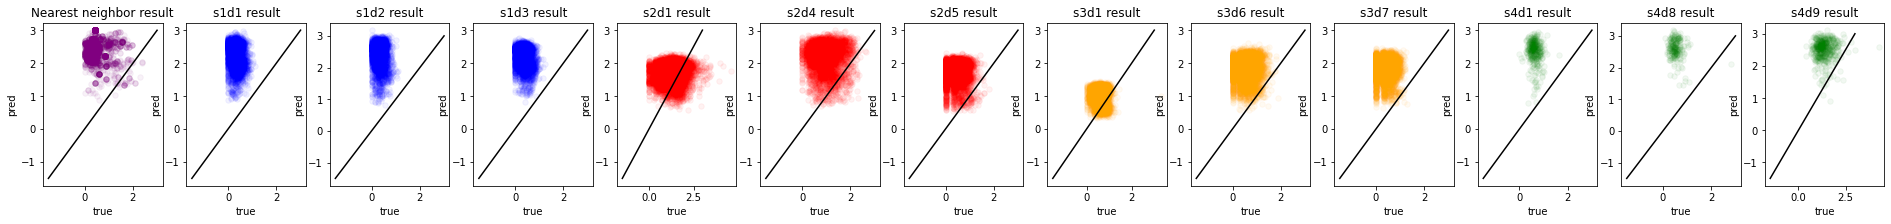

Epoch  100 near loss: 0.15015864 s1d1:  0.24062163 s1d2:  0.19652957 s1d3:  0.21617232 s2d1: 0.8274527 s2d4: 0.6105704 s2d5: 0.29470062 s3d1: 0.25546074 s3d6: 0.35265368 s3d7: 0.29441884 s4d1: 0.27872792 s4d8: 0.28308442 s4d9: 0.9754149 test loss: 0.6922751054802355
Epoch  200 near loss: 0.079031356 s1d1:  0.23526502 s1d2:  0.19534658 s1d3:  0.21853045 s2d1: 0.77092224 s2d4: 0.57647485 s2d5: 0.31137112 s3d1: 0.2840183 s3d6: 0.36573067 s3d7: 0.31061524 s4d1: 0.27876836 s4d8: 0.2964258 s4d9: 0.97414136 test loss: 0.6926132719122757
Epoch  300 near loss: 0.049243305 s1d1:  0.24515472 s1d2:  0.20193595 s1d3:  0.22797686 s2d1: 0.74205554 s2d4: 0.5547361 s2d5: 0.32685193 s3d1: 0.28853688 s3d6: 0.3720674 s3d7: 0.31617928 s4d1: 0.26351324 s4d8: 0.28784707 s4d9: 0.9472995 test loss: 0.6724876220908537
Epoch  400 near loss: 0.03359294 s1d1:  0.24189785 s1d2:  0.19943865 s1d3:  0.22543982 s2d1: 0.74749213 s2d4: 0.56164396 s2d5: 0.3257598 s3d1: 0.2889641 s3d6: 0.37224713 s3d7: 0.31092817 s4d1: 0.2

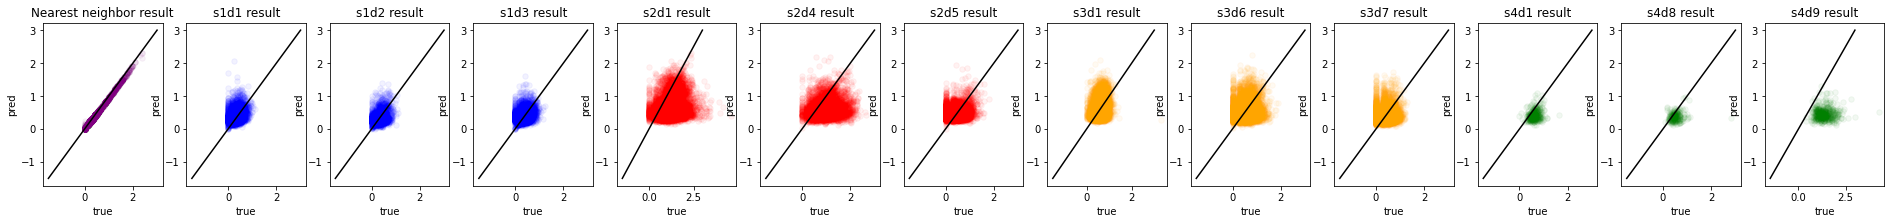

Epoch  1100 near loss: 0.012319274 s1d1:  0.2361487 s1d2:  0.19669369 s1d3:  0.22206888 s2d1: 0.7539847 s2d4: 0.57226014 s2d5: 0.3282543 s3d1: 0.2869181 s3d6: 0.36943704 s3d7: 0.30701974 s4d1: 0.27171028 s4d8: 0.29361466 s4d9: 0.9749805 test loss: 0.6919702430925712
Epoch  1200 near loss: 0.011244951 s1d1:  0.23972999 s1d2:  0.1984386 s1d3:  0.22508971 s2d1: 0.7506561 s2d4: 0.57039356 s2d5: 0.3307907 s3d1: 0.28801727 s3d6: 0.37043843 s3d7: 0.30853662 s4d1: 0.2693765 s4d8: 0.29216644 s4d9: 0.9702436 test loss: 0.688473716773246
Epoch  1300 near loss: 0.010158976 s1d1:  0.23842445 s1d2:  0.1979538 s1d3:  0.22451195 s2d1: 0.74658173 s2d4: 0.56727237 s2d5: 0.3331627 s3d1: 0.2882826 s3d6: 0.37034926 s3d7: 0.3100955 s4d1: 0.26647076 s4d8: 0.29113898 s4d9: 0.965936 test loss: 0.6852180732751197
Epoch  1400 near loss: 0.009918274 s1d1:  0.23713352 s1d2:  0.19686098 s1d3:  0.22340195 s2d1: 0.7512317 s2d4: 0.57241935 s2d5: 0.33096752 s3d1: 0.28990608 s3d6: 0.37081018 s3d7: 0.3084485 s4d1: 0.2706

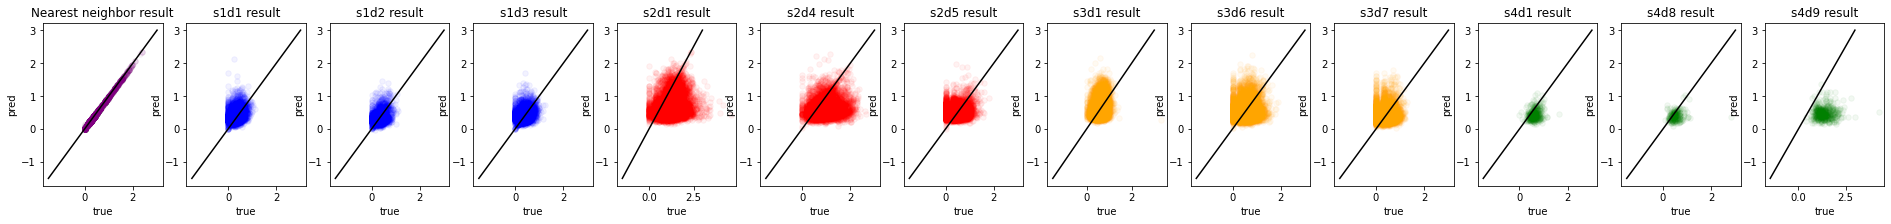

Epoch  2100 near loss: 0.018609505 s1d1:  0.23156494 s1d2:  0.19412176 s1d3:  0.22049057 s2d1: 0.7584792 s2d4: 0.58039635 s2d5: 0.32894015 s3d1: 0.28670728 s3d6: 0.36755353 s3d7: 0.30413172 s4d1: 0.2763529 s4d8: 0.2965878 s4d9: 0.98540235 test loss: 0.6995810641924234
Epoch  2200 near loss: 0.0071772775 s1d1:  0.23934613 s1d2:  0.19817734 s1d3:  0.22644787 s2d1: 0.7444603 s2d4: 0.5694222 s2d5: 0.33613238 s3d1: 0.29170388 s3d6: 0.3711804 s3d7: 0.3103586 s4d1: 0.26728526 s4d8: 0.29059973 s4d9: 0.96672225 test loss: 0.6857853376697388
Epoch  2300 near loss: 0.006331636 s1d1:  0.24024011 s1d2:  0.19874415 s1d3:  0.22737797 s2d1: 0.743294 s2d4: 0.5688573 s2d5: 0.33743832 s3d1: 0.2918362 s3d6: 0.37133208 s3d7: 0.310849 s4d1: 0.26669526 s4d8: 0.29095355 s4d9: 0.96602243 test loss: 0.6852868570649987
Epoch  2400 near loss: 0.0068682516 s1d1:  0.2367694 s1d2:  0.19710056 s1d3:  0.22492395 s2d1: 0.7453924 s2d4: 0.5703185 s2d5: 0.33612874 s3d1: 0.28931266 s3d6: 0.36947238 s3d7: 0.3095574 s4d1: 0.

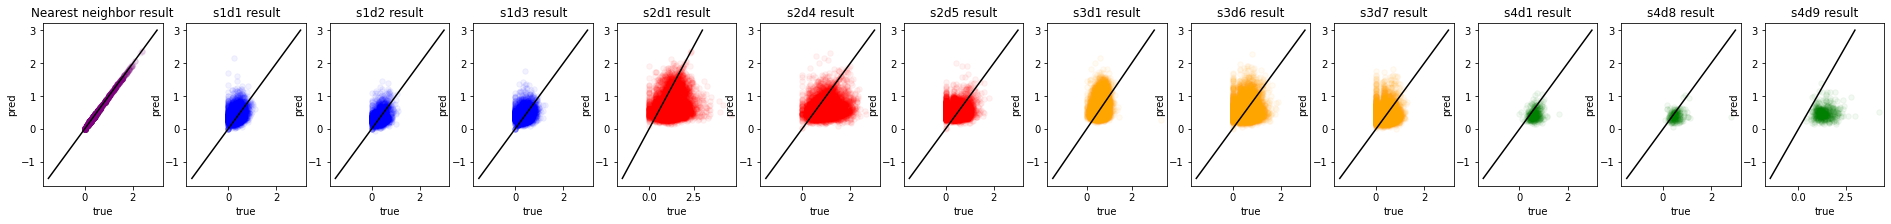

Epoch  3100 near loss: 0.0076889815 s1d1:  0.23882285 s1d2:  0.19862379 s1d3:  0.22735792 s2d1: 0.74156255 s2d4: 0.5681686 s2d5: 0.33979344 s3d1: 0.29017708 s3d6: 0.36991277 s3d7: 0.31075054 s4d1: 0.26550537 s4d8: 0.29028475 s4d9: 0.9628896 test loss: 0.6830463989491327
Epoch  3200 near loss: 0.011841734 s1d1:  0.23421471 s1d2:  0.19582433 s1d3:  0.22337878 s2d1: 0.7512714 s2d4: 0.57647634 s2d5: 0.33431855 s3d1: 0.2891797 s3d6: 0.36869198 s3d7: 0.30702412 s4d1: 0.27332386 s4d8: 0.29576474 s4d9: 0.9780941 test loss: 0.6943847095244573
Epoch  3300 near loss: 0.010101375 s1d1:  0.242101 s1d2:  0.19990648 s1d3:  0.2301528 s2d1: 0.7369524 s2d4: 0.5663092 s2d5: 0.3424372 s3d1: 0.2946193 s3d6: 0.37330973 s3d7: 0.31352946 s4d1: 0.26538283 s4d8: 0.29091188 s4d9: 0.9600545 test loss: 0.6812516079400274
Epoch  3400 near loss: 0.005957779 s1d1:  0.23760912 s1d2:  0.19717917 s1d3:  0.22625618 s2d1: 0.74533635 s2d4: 0.5728994 s2d5: 0.33725643 s3d1: 0.29151857 s3d6: 0.3704334 s3d7: 0.30931956 s4d1: 0

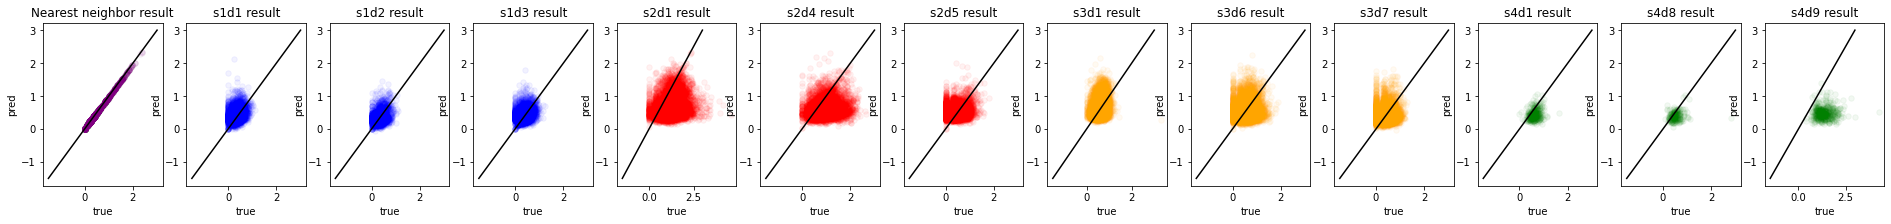

Epoch  4100 near loss: 0.0036555608 s1d1:  0.23808828 s1d2:  0.19782685 s1d3:  0.22710828 s2d1: 0.7429628 s2d4: 0.57085776 s2d5: 0.3395833 s3d1: 0.291723 s3d6: 0.37051296 s3d7: 0.3105014 s4d1: 0.2690413 s4d8: 0.29267007 s4d9: 0.9679333 test loss: 0.6869799818558782
Epoch  4200 near loss: 0.0082742395 s1d1:  0.24023172 s1d2:  0.19894134 s1d3:  0.22902355 s2d1: 0.7373095 s2d4: 0.56700027 s2d5: 0.34269693 s3d1: 0.29182842 s3d6: 0.37063444 s3d7: 0.31233597 s4d1: 0.26463482 s4d8: 0.28950313 s4d9: 0.95956194 test loss: 0.6807114592459766
Epoch  4300 near loss: 0.008156881 s1d1:  0.23636997 s1d2:  0.19683242 s1d3:  0.2257652 s2d1: 0.7458527 s2d4: 0.57404083 s2d5: 0.33751842 s3d1: 0.29097673 s3d6: 0.36907658 s3d7: 0.30845183 s4d1: 0.27007774 s4d8: 0.2928041 s4d9: 0.9708681 test loss: 0.6890254453829523
Epoch  4400 near loss: 0.00434926 s1d1:  0.23855126 s1d2:  0.19800659 s1d3:  0.227786 s2d1: 0.7393199 s2d4: 0.56904423 s2d5: 0.34146348 s3d1: 0.29240552 s3d6: 0.37050575 s3d7: 0.31125015 s4d1: 0

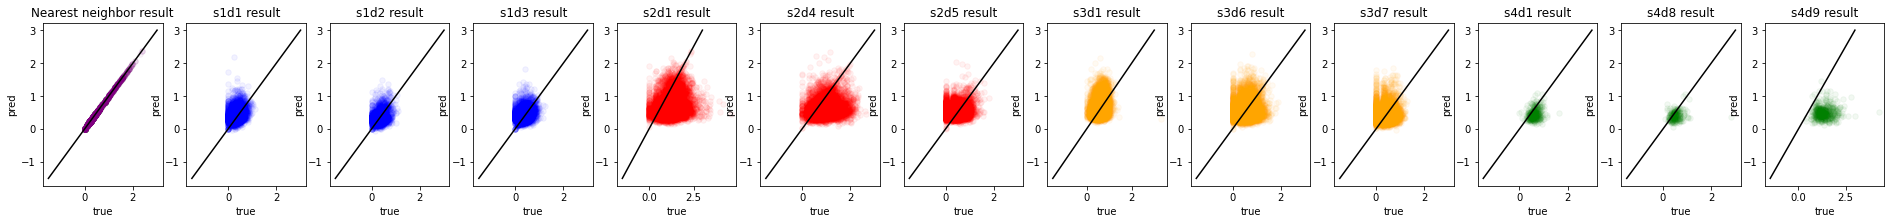

Epoch  5100 near loss: 0.003530129 s1d1:  0.23810907 s1d2:  0.19783281 s1d3:  0.22785251 s2d1: 0.74023443 s2d4: 0.5703913 s2d5: 0.34133598 s3d1: 0.29198882 s3d6: 0.3701427 s3d7: 0.31076038 s4d1: 0.26771367 s4d8: 0.29159704 s4d9: 0.9650349 test loss: 0.6848373108936887
Epoch  5200 near loss: 0.0039758324 s1d1:  0.23866943 s1d2:  0.19791952 s1d3:  0.22805 s2d1: 0.7403592 s2d4: 0.5705018 s2d5: 0.34092298 s3d1: 0.2929786 s3d6: 0.37083516 s3d7: 0.31107512 s4d1: 0.26838678 s4d8: 0.29199094 s4d9: 0.96605617 test loss: 0.6856204948998841
Epoch  5300 near loss: 0.0070430054 s1d1:  0.236165 s1d2:  0.19667812 s1d3:  0.2259576 s2d1: 0.74345505 s2d4: 0.57319134 s2d5: 0.33915672 s3d1: 0.29079568 s3d6: 0.36906847 s3d7: 0.30916205 s4d1: 0.27001753 s4d8: 0.29271927 s4d9: 0.96988565 test loss: 0.6883747186586159
Epoch  5400 near loss: 0.013913604 s1d1:  0.23498929 s1d2:  0.196008 s1d3:  0.2251091 s2d1: 0.74761575 s2d4: 0.57645637 s2d5: 0.33667573 s3d1: 0.29018155 s3d6: 0.3681845 s3d7: 0.30748346 s4d1: 0

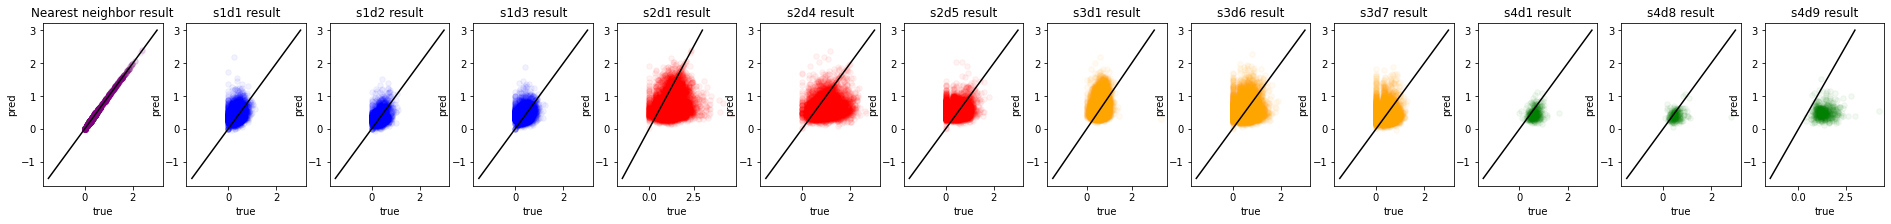

Epoch  6100 near loss: 0.0046243845 s1d1:  0.23865768 s1d2:  0.19806723 s1d3:  0.22853087 s2d1: 0.7392445 s2d4: 0.5696 s2d5: 0.34148118 s3d1: 0.29190648 s3d6: 0.36950755 s3d7: 0.31074238 s4d1: 0.26639533 s4d8: 0.289905 s4d9: 0.9627546 test loss: 0.6830414134948954
Epoch  6200 near loss: 0.01465037 s1d1:  0.23553436 s1d2:  0.19632533 s1d3:  0.22584791 s2d1: 0.7470866 s2d4: 0.5764093 s2d5: 0.33670202 s3d1: 0.29002497 s3d6: 0.36772403 s3d7: 0.30752498 s4d1: 0.27129334 s4d8: 0.29274723 s4d9: 0.97328097 test loss: 0.6907402691994889
Epoch  6300 near loss: 0.0059257555 s1d1:  0.24179825 s1d2:  0.19926439 s1d3:  0.23094709 s2d1: 0.7352132 s2d4: 0.567478 s2d5: 0.34358358 s3d1: 0.2953591 s3d6: 0.37226465 s3d7: 0.31316364 s4d1: 0.26532716 s4d8: 0.28935915 s4d9: 0.9588297 test loss: 0.6803150769265065
Epoch  6400 near loss: 0.0041182893 s1d1:  0.23989211 s1d2:  0.19859937 s1d3:  0.22935264 s2d1: 0.7408433 s2d4: 0.571289 s2d5: 0.3406698 s3d1: 0.29334316 s3d6: 0.3705584 s3d7: 0.31094512 s4d1: 0.268

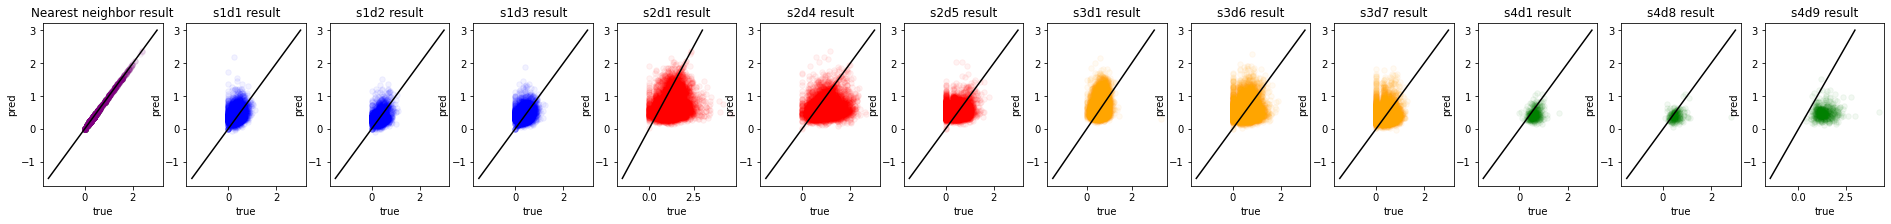

Epoch  7100 near loss: 0.0076203463 s1d1:  0.23775248 s1d2:  0.19739571 s1d3:  0.22810197 s2d1: 0.74245113 s2d4: 0.5730023 s2d5: 0.3394615 s3d1: 0.29135314 s3d6: 0.36907554 s3d7: 0.30949417 s4d1: 0.2687199 s4d8: 0.2910218 s4d9: 0.96664184 test loss: 0.6859576028993247
Epoch  7200 near loss: 0.009290573 s1d1:  0.23728384 s1d2:  0.19702992 s1d3:  0.22759178 s2d1: 0.7432137 s2d4: 0.5740572 s2d5: 0.33881107 s3d1: 0.29221994 s3d6: 0.3693832 s3d7: 0.30924064 s4d1: 0.26987118 s4d8: 0.29160908 s4d9: 0.96915597 test loss: 0.6877860426862096
Epoch  7300 near loss: 0.0038261714 s1d1:  0.24006778 s1d2:  0.19840175 s1d3:  0.2301296 s2d1: 0.73834467 s2d4: 0.57025653 s2d5: 0.34204337 s3d1: 0.29345602 s3d6: 0.37095755 s3d7: 0.31105042 s4d1: 0.26715702 s4d8: 0.29032165 s4d9: 0.9624173 test loss: 0.6829592075894363
Epoch  7400 near loss: 0.007572577 s1d1:  0.23841304 s1d2:  0.19757761 s1d3:  0.22842018 s2d1: 0.7414933 s2d4: 0.5719324 s2d5: 0.33947372 s3d1: 0.29147217 s3d6: 0.36908248 s3d7: 0.30962718 s4

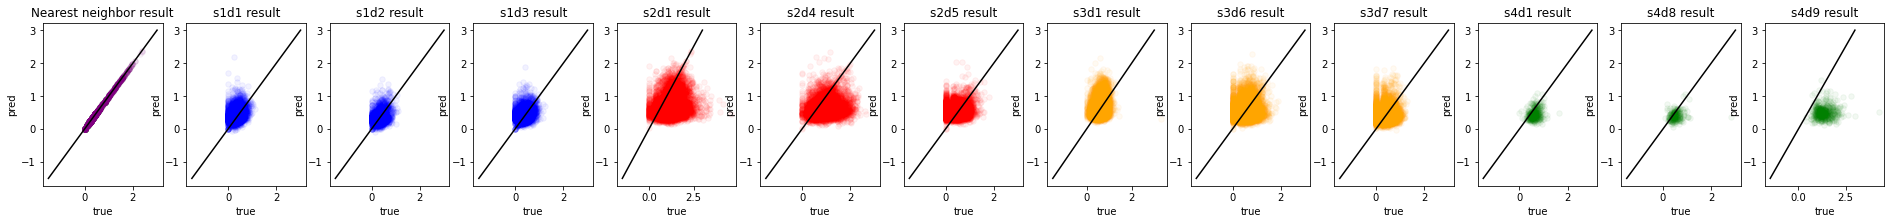

Epoch  8100 near loss: 0.003450008 s1d1:  0.24062198 s1d2:  0.19874592 s1d3:  0.230522 s2d1: 0.737125 s2d4: 0.5691924 s2d5: 0.34241825 s3d1: 0.29273188 s3d6: 0.3702564 s3d7: 0.31138986 s4d1: 0.2661919 s4d8: 0.2889861 s4d9: 0.9605531 test loss: 0.6815099225038207
Epoch  8200 near loss: 0.01102527 s1d1:  0.23707153 s1d2:  0.19681953 s1d3:  0.2273011 s2d1: 0.7434382 s2d4: 0.5738968 s2d5: 0.33867002 s3d1: 0.29058328 s3d6: 0.36837247 s3d7: 0.30845386 s4d1: 0.26941305 s4d8: 0.29073638 s4d9: 0.9674062 test loss: 0.686517727172892
Epoch  8300 near loss: 0.004054487 s1d1:  0.24002524 s1d2:  0.19835143 s1d3:  0.23008 s2d1: 0.7386074 s2d4: 0.5706923 s2d5: 0.34177396 s3d1: 0.29326653 s3d6: 0.3704071 s3d7: 0.31085953 s4d1: 0.26764268 s4d8: 0.28989404 s4d9: 0.96270585 test loss: 0.6831717588205026
Epoch  8400 near loss: 0.0031092728 s1d1:  0.24025185 s1d2:  0.19852455 s1d3:  0.23027584 s2d1: 0.7365276 s2d4: 0.56900996 s2d5: 0.34287432 s3d1: 0.29297838 s3d6: 0.37036383 s3d7: 0.3115869 s4d1: 0.2660749

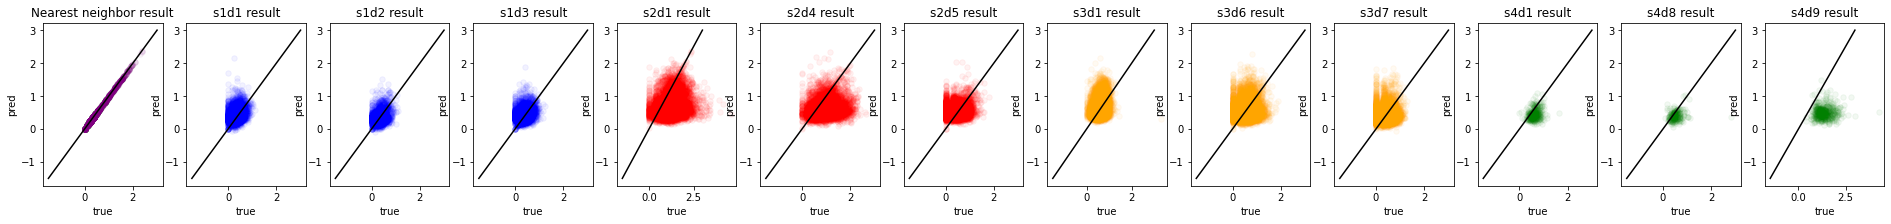

Epoch  9100 near loss: 0.00622545 s1d1:  0.24291514 s1d2:  0.19999322 s1d3:  0.23268062 s2d1: 0.7321317 s2d4: 0.5660477 s2d5: 0.34593165 s3d1: 0.29408672 s3d6: 0.37134773 s3d7: 0.31332916 s4d1: 0.26354337 s4d8: 0.2873996 s4d9: 0.95408756 test loss: 0.6768425506781249
Epoch  9200 near loss: 0.0036850164 s1d1:  0.2402697 s1d2:  0.19835652 s1d3:  0.23021151 s2d1: 0.7367432 s2d4: 0.56938255 s2d5: 0.3430167 s3d1: 0.2925891 s3d6: 0.3700316 s3d7: 0.3112176 s4d1: 0.2665274 s4d8: 0.28900936 s4d9: 0.9601182 test loss: 0.6812744123509784
Epoch  9300 near loss: 0.00461165 s1d1:  0.24159388 s1d2:  0.19933654 s1d3:  0.23141147 s2d1: 0.7341901 s2d4: 0.56698644 s2d5: 0.34460756 s3d1: 0.2923562 s3d6: 0.37028202 s3d7: 0.31217864 s4d1: 0.26407468 s4d8: 0.28767434 s4d9: 0.9549378 test loss: 0.677485942627656
Epoch  9400 near loss: 0.003946007 s1d1:  0.24064636 s1d2:  0.1987274 s1d3:  0.23080385 s2d1: 0.7350761 s2d4: 0.5682343 s2d5: 0.3439672 s3d1: 0.29226163 s3d6: 0.37012798 s3d7: 0.31147012 s4d1: 0.26429

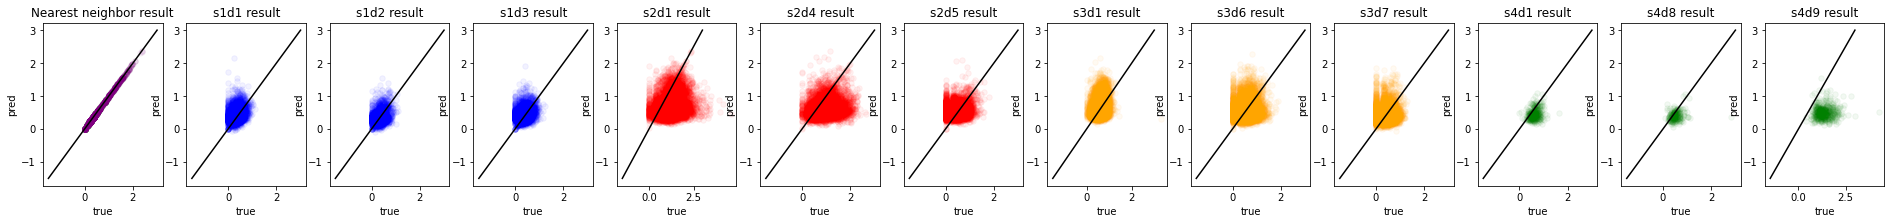

Epoch  10100 near loss: 0.0047631147 s1d1:  0.24073063 s1d2:  0.19846141 s1d3:  0.23108199 s2d1: 0.7368515 s2d4: 0.5701913 s2d5: 0.34257448 s3d1: 0.2927776 s3d6: 0.37028965 s3d7: 0.31095773 s4d1: 0.2668787 s4d8: 0.2892359 s4d9: 0.96036243 test loss: 0.6814982276985817
Epoch  10200 near loss: 0.0033573585 s1d1:  0.24201219 s1d2:  0.19926076 s1d3:  0.23215479 s2d1: 0.7341261 s2d4: 0.56829125 s2d5: 0.34445292 s3d1: 0.29404956 s3d6: 0.37107015 s3d7: 0.31217942 s4d1: 0.26537514 s4d8: 0.28805172 s4d9: 0.9568567 test loss: 0.6789300451619146
Epoch  10300 near loss: 0.0031497648 s1d1:  0.24083818 s1d2:  0.19864681 s1d3:  0.2310397 s2d1: 0.7356515 s2d4: 0.569096 s2d5: 0.3434551 s3d1: 0.2928804 s3d6: 0.3701326 s3d7: 0.31114572 s4d1: 0.26523504 s4d8: 0.28779045 s4d9: 0.95737916 test loss: 0.6792268081480576
Epoch  10400 near loss: 0.007912366 s1d1:  0.24464205 s1d2:  0.20044933 s1d3:  0.23424913 s2d1: 0.7303767 s2d4: 0.56537306 s2d5: 0.3463907 s3d1: 0.29584283 s3d6: 0.3723478 s3d7: 0.31393513 s4d

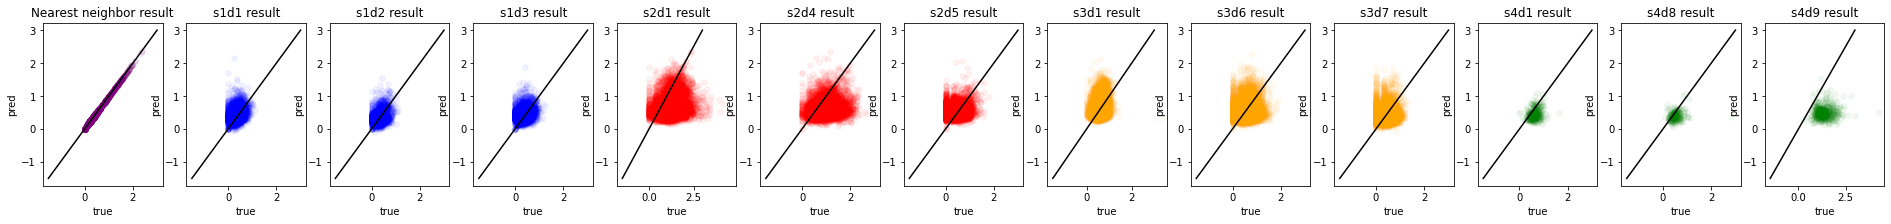

Epoch  11100 near loss: 0.007178043 s1d1:  0.24393162 s1d2:  0.20023361 s1d3:  0.2338087 s2d1: 0.7304256 s2d4: 0.5656924 s2d5: 0.34691843 s3d1: 0.2951762 s3d6: 0.37216476 s3d7: 0.31373882 s4d1: 0.26343292 s4d8: 0.28674397 s4d9: 0.9515217 test loss: 0.675110492636685
Epoch  11200 near loss: 0.003868533 s1d1:  0.24179517 s1d2:  0.19914415 s1d3:  0.23213261 s2d1: 0.7330896 s2d4: 0.56747884 s2d5: 0.34512982 s3d1: 0.2931749 s3d6: 0.3707892 s3d7: 0.3120306 s4d1: 0.26488173 s4d8: 0.28731158 s4d9: 0.95432687 test loss: 0.6771640889548812
Epoch  11300 near loss: 0.015774155 s1d1:  0.23742256 s1d2:  0.196546 s1d3:  0.22805785 s2d1: 0.74347454 s2d4: 0.575638 s2d5: 0.3383494 s3d1: 0.29042393 s3d6: 0.36821768 s3d7: 0.307816 s4d1: 0.2707406 s4d8: 0.29036927 s4d9: 0.96781254 test loss: 0.6869227595967752
Epoch  11400 near loss: 0.0044698217 s1d1:  0.239987 s1d2:  0.198132 s1d3:  0.23056723 s2d1: 0.7372006 s2d4: 0.5705413 s2d5: 0.34244654 s3d1: 0.29170197 s3d6: 0.36936224 s3d7: 0.31020066 s4d1: 0.2663

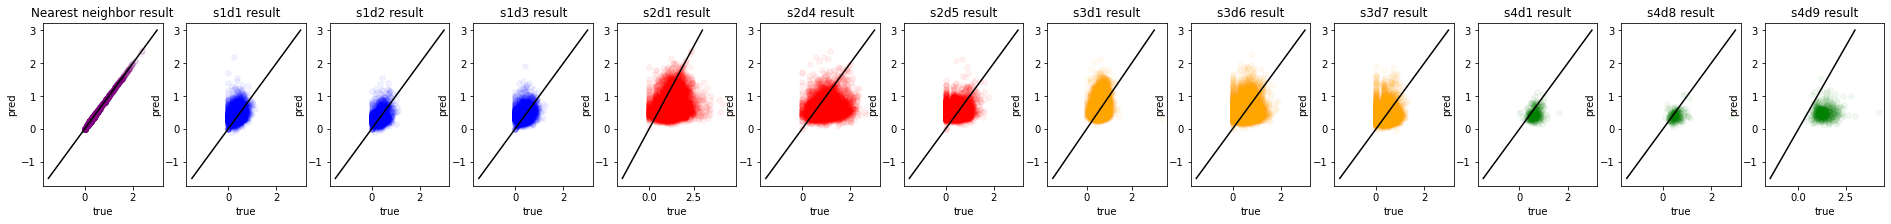

Epoch  12100 near loss: 0.0039428296 s1d1:  0.2402921 s1d2:  0.19821936 s1d3:  0.23090938 s2d1: 0.73554254 s2d4: 0.5695113 s2d5: 0.34357157 s3d1: 0.29271105 s3d6: 0.37000018 s3d7: 0.31090525 s4d1: 0.26598504 s4d8: 0.28773996 s4d9: 0.95750064 test loss: 0.6793989215592183
Epoch  12200 near loss: 0.006791099 s1d1:  0.23962314 s1d2:  0.19783923 s1d3:  0.23023413 s2d1: 0.7369595 s2d4: 0.5710698 s2d5: 0.34272358 s3d1: 0.29179367 s3d6: 0.36924627 s3d7: 0.30996233 s4d1: 0.26691446 s4d8: 0.28813115 s4d9: 0.9591721 test loss: 0.6806360584119064
Epoch  12300 near loss: 0.004785221 s1d1:  0.24140869 s1d2:  0.19858657 s1d3:  0.2316788 s2d1: 0.7362326 s2d4: 0.5698952 s2d5: 0.3430408 s3d1: 0.292276 s3d6: 0.36973023 s3d7: 0.31073204 s4d1: 0.26590517 s4d8: 0.2873585 s4d9: 0.9564422 test loss: 0.6786703406617711
Epoch  12400 near loss: 0.0033926915 s1d1:  0.24102171 s1d2:  0.19869517 s1d3:  0.23142761 s2d1: 0.7345991 s2d4: 0.5689249 s2d5: 0.34425867 s3d1: 0.2923709 s3d6: 0.36990264 s3d7: 0.31117064 s4d

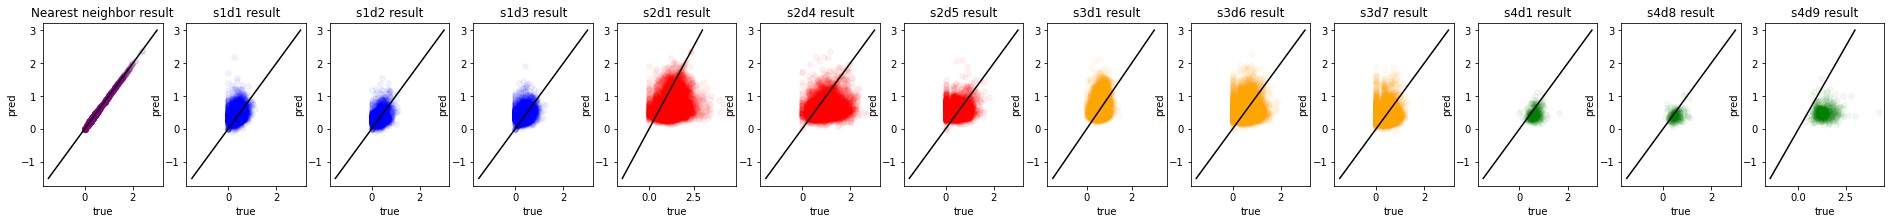

Epoch  13100 near loss: 0.003235727 s1d1:  0.24228208 s1d2:  0.19935372 s1d3:  0.2327672 s2d1: 0.7335902 s2d4: 0.5682721 s2d5: 0.3449804 s3d1: 0.2936976 s3d6: 0.37117392 s3d7: 0.31183138 s4d1: 0.2650822 s4d8: 0.2873955 s4d9: 0.95428616 test loss: 0.6771713201861236
Epoch  13200 near loss: 0.003960268 s1d1:  0.24401899 s1d2:  0.20020139 s1d3:  0.23432904 s2d1: 0.73090756 s2d4: 0.56645584 s2d5: 0.346792 s3d1: 0.29421592 s3d6: 0.37118983 s3d7: 0.31283385 s4d1: 0.26327822 s4d8: 0.28618965 s4d9: 0.95094514 test loss: 0.6746686154978575
Epoch  13300 near loss: 0.0034410509 s1d1:  0.24128537 s1d2:  0.19861253 s1d3:  0.23196054 s2d1: 0.73411715 s2d4: 0.5689918 s2d5: 0.34442076 s3d1: 0.29287654 s3d6: 0.3701213 s3d7: 0.31099164 s4d1: 0.26540524 s4d8: 0.28709343 s4d9: 0.95513284 test loss: 0.6777347434699736
Epoch  13400 near loss: 0.007070339 s1d1:  0.24060188 s1d2:  0.1983363 s1d3:  0.23142672 s2d1: 0.73719335 s2d4: 0.570895 s2d5: 0.34259903 s3d1: 0.2913266 s3d6: 0.36919686 s3d7: 0.30993387 s4d

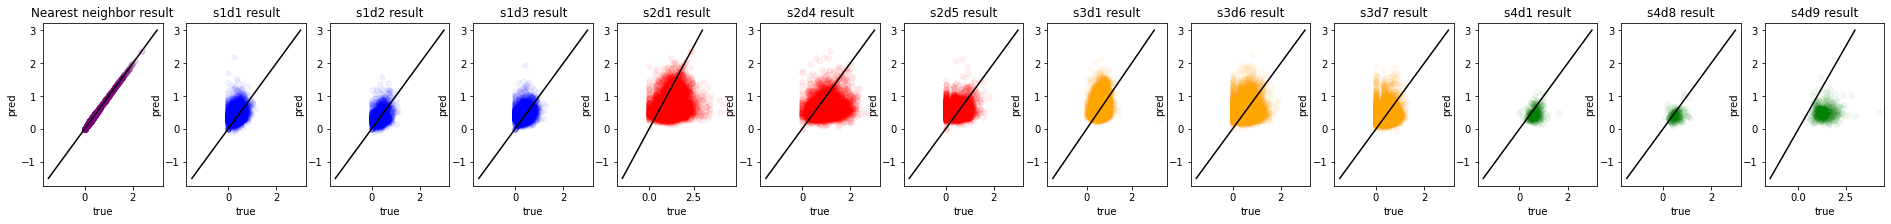

Epoch  14100 near loss: 0.005962084 s1d1:  0.24520849 s1d2:  0.20095707 s1d3:  0.23550709 s2d1: 0.7301987 s2d4: 0.56587356 s2d5: 0.34728315 s3d1: 0.2947794 s3d6: 0.37213328 s3d7: 0.3134831 s4d1: 0.26280788 s4d8: 0.28565916 s4d9: 0.9486693 test loss: 0.6730883735531628
Epoch  14200 near loss: 0.0027691186 s1d1:  0.2428685 s1d2:  0.19950594 s1d3:  0.23320344 s2d1: 0.73300976 s2d4: 0.56783915 s2d5: 0.34535128 s3d1: 0.2929346 s3d6: 0.3705168 s3d7: 0.3117835 s4d1: 0.26461104 s4d8: 0.28642303 s4d9: 0.9527992 test loss: 0.6760625092306364
Epoch  14300 near loss: 0.0039429883 s1d1:  0.24483217 s1d2:  0.20028244 s1d3:  0.23485218 s2d1: 0.7311913 s2d4: 0.5668929 s2d5: 0.34615612 s3d1: 0.29443526 s3d6: 0.37173823 s3d7: 0.31271964 s4d1: 0.2635803 s4d8: 0.2855599 s4d9: 0.95026445 test loss: 0.6742124168821267
Epoch  14400 near loss: 0.0046990924 s1d1:  0.24354687 s1d2:  0.19997944 s1d3:  0.23388587 s2d1: 0.73127484 s2d4: 0.56688476 s2d5: 0.34658983 s3d1: 0.29377756 s3d6: 0.3713631 s3d7: 0.3124133 s

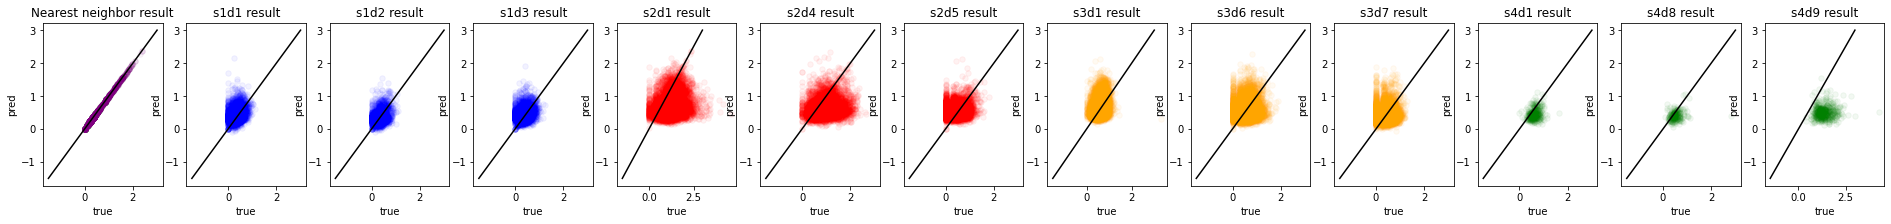

Epoch  15100 near loss: 0.004210218 s1d1:  0.2444651 s1d2:  0.2003188 s1d3:  0.2350054 s2d1: 0.7303547 s2d4: 0.5662426 s2d5: 0.34676453 s3d1: 0.29391927 s3d6: 0.37145194 s3d7: 0.31286475 s4d1: 0.2633365 s4d8: 0.2857218 s4d9: 0.9494662 test loss: 0.6736783880077967
Epoch  15200 near loss: 0.0027913074 s1d1:  0.24381536 s1d2:  0.19999817 s1d3:  0.23430958 s2d1: 0.73304653 s2d4: 0.5686263 s2d5: 0.34518057 s3d1: 0.29324192 s3d6: 0.37092683 s3d7: 0.31177017 s4d1: 0.2655082 s4d8: 0.28672576 s4d9: 0.95337164 test loss: 0.6765767794042636
Epoch  15300 near loss: 0.0034668332 s1d1:  0.2437453 s1d2:  0.19965057 s1d3:  0.23405664 s2d1: 0.73209095 s2d4: 0.56756914 s2d5: 0.34549266 s3d1: 0.29357335 s3d6: 0.37122247 s3d7: 0.31203118 s4d1: 0.26416665 s4d8: 0.28592744 s4d9: 0.95121837 test loss: 0.674938344512741
Epoch  15400 near loss: 0.0028061687 s1d1:  0.24356581 s1d2:  0.19969057 s1d3:  0.23400162 s2d1: 0.73292583 s2d4: 0.56846696 s2d5: 0.34524813 s3d1: 0.2935342 s3d6: 0.37101078 s3d7: 0.31185263

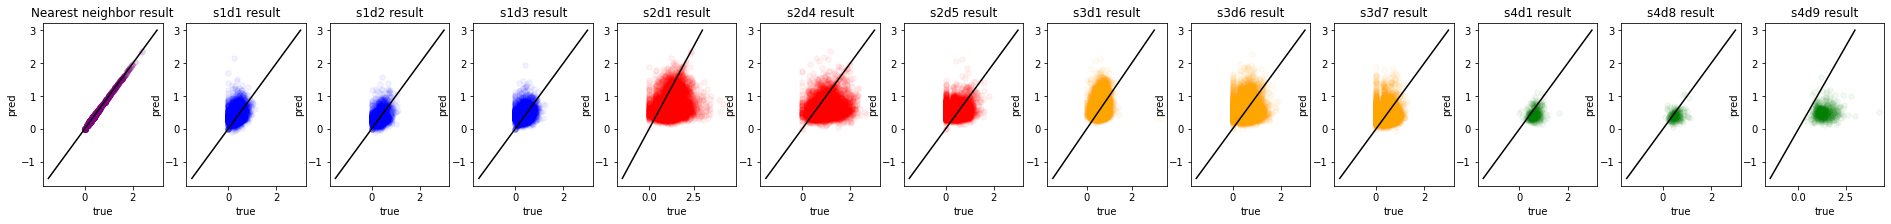

Epoch  16100 near loss: 0.00407426 s1d1:  0.24509679 s1d2:  0.2004782 s1d3:  0.23537362 s2d1: 0.73019654 s2d4: 0.5662076 s2d5: 0.34682253 s3d1: 0.2938312 s3d6: 0.37134513 s3d7: 0.31292415 s4d1: 0.26274535 s4d8: 0.28479055 s4d9: 0.9483466 test loss: 0.6727952463807645
Epoch  16200 near loss: 0.004498837 s1d1:  0.24290632 s1d2:  0.19925515 s1d3:  0.23345314 s2d1: 0.73383325 s2d4: 0.569356 s2d5: 0.34457117 s3d1: 0.29320627 s3d6: 0.37059206 s3d7: 0.31117752 s4d1: 0.26581085 s4d8: 0.28683695 s4d9: 0.95398015 test loss: 0.6770197724378161
Epoch  16300 near loss: 0.004062281 s1d1:  0.24246822 s1d2:  0.19909398 s1d3:  0.23313381 s2d1: 0.7332392 s2d4: 0.56879354 s2d5: 0.3450234 s3d1: 0.2926275 s3d6: 0.37029907 s3d7: 0.31120285 s4d1: 0.26501262 s4d8: 0.28651035 s4d9: 0.9529621 test loss: 0.6762280845693711
Epoch  16400 near loss: 0.003710566 s1d1:  0.24461663 s1d2:  0.20025131 s1d3:  0.23505881 s2d1: 0.73080546 s2d4: 0.5666851 s2d5: 0.3468649 s3d1: 0.29340222 s3d6: 0.37108234 s3d7: 0.3124011 s4d

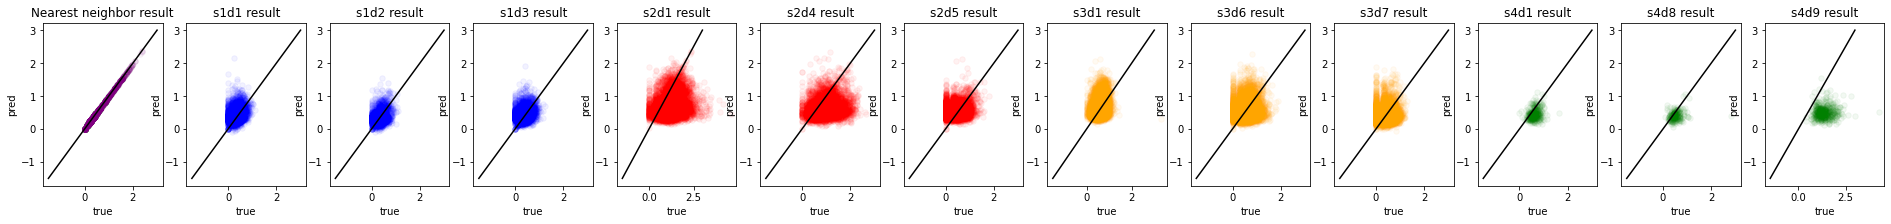

Epoch  17100 near loss: 0.002693179 s1d1:  0.24429369 s1d2:  0.20012955 s1d3:  0.23480982 s2d1: 0.73107654 s2d4: 0.5671155 s2d5: 0.34652567 s3d1: 0.2931202 s3d6: 0.37103048 s3d7: 0.31217808 s4d1: 0.26415315 s4d8: 0.28577232 s4d9: 0.9500001 test loss: 0.6741349286910676
Epoch  17200 near loss: 0.0039378544 s1d1:  0.2452225 s1d2:  0.20060164 s1d3:  0.23578005 s2d1: 0.7294665 s2d4: 0.5660307 s2d5: 0.3475383 s3d1: 0.29421586 s3d6: 0.37187618 s3d7: 0.31326917 s4d1: 0.26372746 s4d8: 0.28542185 s4d9: 0.9484723 test loss: 0.6730602398573272
Epoch  17300 near loss: 0.006477752 s1d1:  0.24269481 s1d2:  0.19923766 s1d3:  0.23332395 s2d1: 0.735444 s2d4: 0.5701302 s2d5: 0.34344405 s3d1: 0.29142016 s3d6: 0.36969885 s3d7: 0.3103788 s4d1: 0.26581377 s4d8: 0.28629836 s4d9: 0.954337 test loss: 0.6772037845424055
Epoch  17400 near loss: 0.007251671 s1d1:  0.24145414 s1d2:  0.19848579 s1d3:  0.2323652 s2d1: 0.73719925 s2d4: 0.571618 s2d5: 0.34264162 s3d1: 0.29127395 s3d6: 0.36953232 s3d7: 0.3095782 s4d1: 

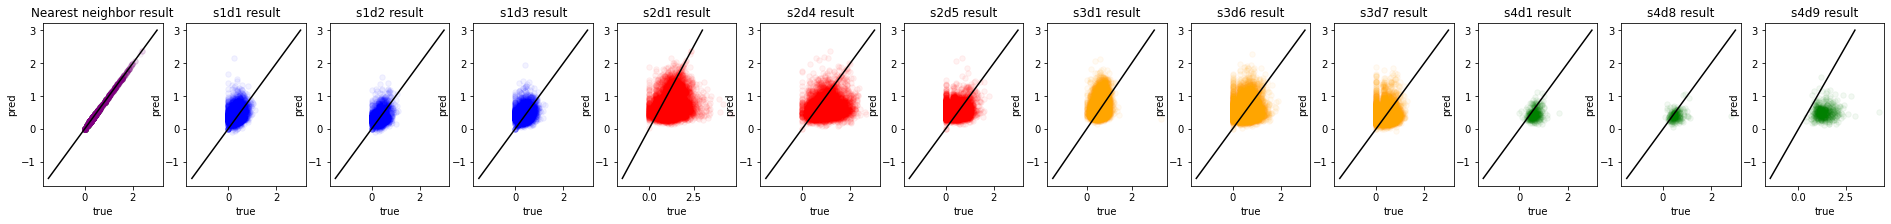

Epoch  18100 near loss: 0.007520923 s1d1:  0.24133055 s1d2:  0.19832915 s1d3:  0.23211174 s2d1: 0.73582053 s2d4: 0.57081306 s2d5: 0.34320012 s3d1: 0.29127526 s3d6: 0.36964744 s3d7: 0.30980965 s4d1: 0.26637504 s4d8: 0.28674364 s4d9: 0.9553425 test loss: 0.6779667427653525
Epoch  18200 near loss: 0.00939803 s1d1:  0.2402774 s1d2:  0.19795173 s1d3:  0.23123397 s2d1: 0.7377962 s2d4: 0.57191586 s2d5: 0.3420148 s3d1: 0.29019782 s3d6: 0.36874753 s3d7: 0.30906513 s4d1: 0.26733503 s4d8: 0.28716776 s4d9: 0.95737284 test loss: 0.6794431067139693
Epoch  18300 near loss: 0.0023479485 s1d1:  0.2445676 s1d2:  0.20000248 s1d3:  0.2350719 s2d1: 0.7310007 s2d4: 0.5671087 s2d5: 0.34621793 s3d1: 0.293134 s3d6: 0.37105513 s3d7: 0.3122233 s4d1: 0.2640104 s4d8: 0.2857906 s4d9: 0.9498691 test loss: 0.674033109351786
Epoch  18400 near loss: 0.0034993067 s1d1:  0.24392492 s1d2:  0.19961669 s1d3:  0.23445128 s2d1: 0.73308724 s2d4: 0.56856817 s2d5: 0.34503257 s3d1: 0.29239017 s3d6: 0.37059292 s3d7: 0.31142864 s4d

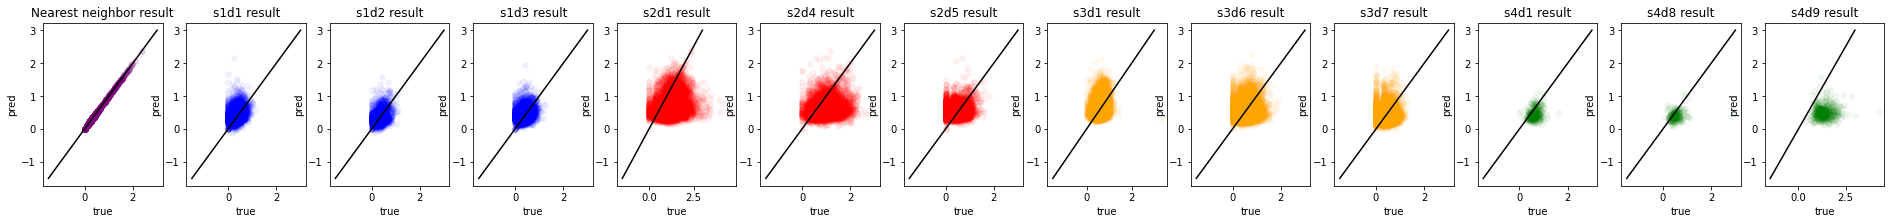

Epoch  19100 near loss: 0.01003676 s1d1:  0.24178708 s1d2:  0.19855912 s1d3:  0.23246859 s2d1: 0.7382332 s2d4: 0.5717108 s2d5: 0.34176663 s3d1: 0.2897485 s3d6: 0.36889258 s3d7: 0.3092472 s4d1: 0.26673996 s4d8: 0.286904 s4d9: 0.95651567 test loss: 0.6787874889646413
Epoch  19200 near loss: 0.0026407337 s1d1:  0.2447023 s1d2:  0.20016706 s1d3:  0.23530063 s2d1: 0.7311083 s2d4: 0.5670827 s2d5: 0.3464516 s3d1: 0.292793 s3d6: 0.37136328 s3d7: 0.31209978 s4d1: 0.2643516 s4d8: 0.28603902 s4d9: 0.94909596 test loss: 0.6735995540665274
Epoch  19300 near loss: 0.005135025 s1d1:  0.24288307 s1d2:  0.19911397 s1d3:  0.23365575 s2d1: 0.7342289 s2d4: 0.5694072 s2d5: 0.3441628 s3d1: 0.29191118 s3d6: 0.370393 s3d7: 0.31069183 s4d1: 0.26562676 s4d8: 0.28630888 s4d9: 0.95260054 test loss: 0.6760570546205363
Epoch  19400 near loss: 0.004955693 s1d1:  0.2421785 s1d2:  0.19891238 s1d3:  0.23306818 s2d1: 0.73431873 s2d4: 0.5690475 s2d5: 0.34429628 s3d1: 0.2906196 s3d6: 0.3696995 s3d7: 0.31024027 s4d1: 0.265

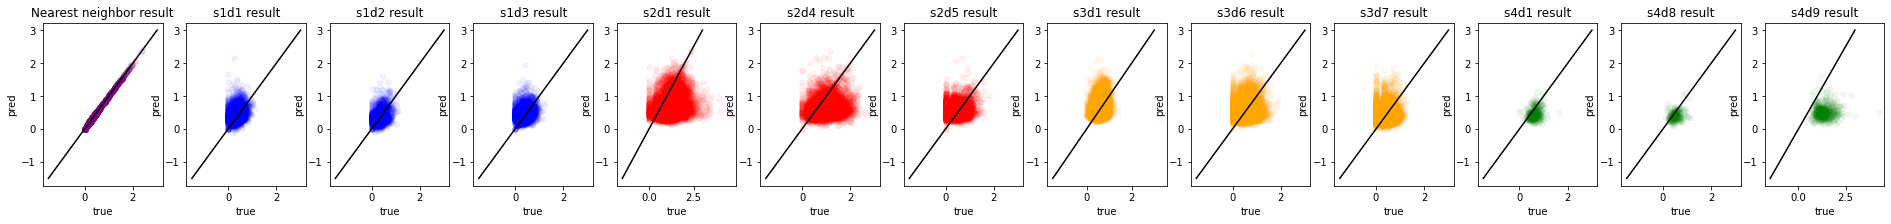

Epoch  20100 near loss: 0.0033455647 s1d1:  0.24516217 s1d2:  0.2002417 s1d3:  0.23576164 s2d1: 0.73197603 s2d4: 0.5677318 s2d5: 0.34543544 s3d1: 0.29239142 s3d6: 0.37105888 s3d7: 0.3117382 s4d1: 0.2643731 s4d8: 0.2856613 s4d9: 0.9493655 test loss: 0.6737435158006603
Epoch  20200 near loss: 0.003657838 s1d1:  0.2437437 s1d2:  0.19954821 s1d3:  0.2345023 s2d1: 0.731584 s2d4: 0.56747913 s2d5: 0.34555402 s3d1: 0.29287943 s3d6: 0.37112007 s3d7: 0.311664 s4d1: 0.2644349 s4d8: 0.28555593 s4d9: 0.9494778 test loss: 0.6738150112534593
Epoch  20300 near loss: 0.0031897088 s1d1:  0.2446305 s1d2:  0.19994067 s1d3:  0.23534921 s2d1: 0.7309416 s2d4: 0.5675345 s2d5: 0.34634405 s3d1: 0.29304278 s3d6: 0.37121463 s3d7: 0.31190428 s4d1: 0.26414096 s4d8: 0.28532293 s4d9: 0.9485813 test loss: 0.6731761920112647
Epoch  20400 near loss: 0.0047287694 s1d1:  0.24655516 s1d2:  0.20116597 s1d3:  0.23721765 s2d1: 0.72781074 s2d4: 0.56497866 s2d5: 0.34862497 s3d1: 0.2938241 s3d6: 0.372016 s3d7: 0.31335533 s4d1: 0

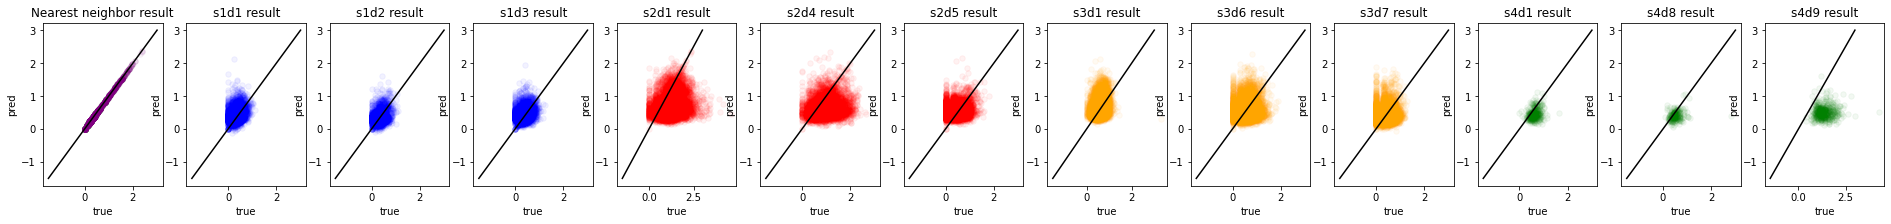

Epoch  21100 near loss: 0.006589353 s1d1:  0.2417498 s1d2:  0.19873533 s1d3:  0.23283353 s2d1: 0.7352937 s2d4: 0.57020247 s2d5: 0.34365594 s3d1: 0.29037446 s3d6: 0.36944443 s3d7: 0.3095822 s4d1: 0.2665134 s4d8: 0.28679708 s4d9: 0.9540239 test loss: 0.6771368246125227
Epoch  21200 near loss: 0.0048570535 s1d1:  0.24268712 s1d2:  0.19912767 s1d3:  0.23372208 s2d1: 0.73392034 s2d4: 0.5688843 s2d5: 0.3441087 s3d1: 0.290991 s3d6: 0.37005115 s3d7: 0.31061852 s4d1: 0.26555815 s4d8: 0.28635782 s4d9: 0.9523361 test loss: 0.6758812829824525
Epoch  21300 near loss: 0.0052647814 s1d1:  0.24315825 s1d2:  0.19926608 s1d3:  0.23421775 s2d1: 0.732541 s2d4: 0.56868756 s2d5: 0.34500197 s3d1: 0.29110652 s3d6: 0.36988723 s3d7: 0.31066617 s4d1: 0.26547724 s4d8: 0.2863717 s4d9: 0.9512841 test loss: 0.6751915580693681
Epoch  21400 near loss: 0.0024785735 s1d1:  0.2450517 s1d2:  0.20034084 s1d3:  0.2359449 s2d1: 0.7296762 s2d4: 0.5665064 s2d5: 0.34678155 s3d1: 0.29304862 s3d6: 0.37143096 s3d7: 0.3123834 s4d1:

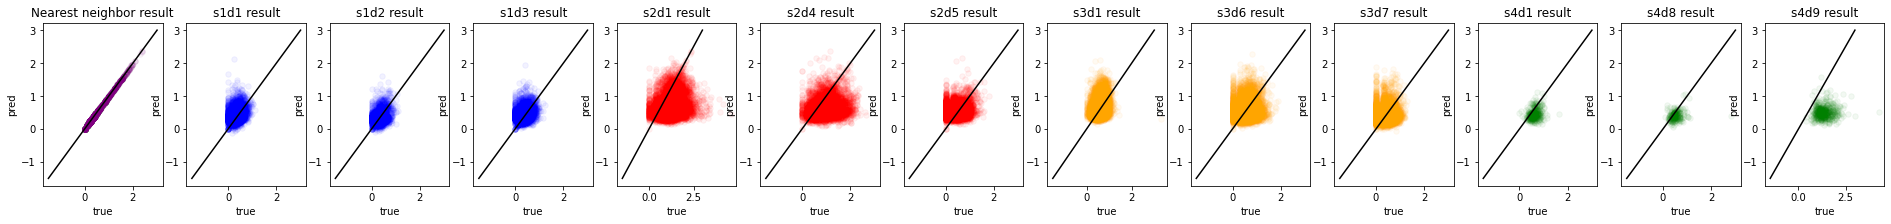

Epoch  22100 near loss: 0.0033497438 s1d1:  0.2431108 s1d2:  0.19923522 s1d3:  0.23420034 s2d1: 0.73341495 s2d4: 0.5689998 s2d5: 0.34486845 s3d1: 0.2911214 s3d6: 0.3703944 s3d7: 0.31061733 s4d1: 0.26604927 s4d8: 0.2869377 s4d9: 0.9518707 test loss: 0.6756957610306051
Epoch  22200 near loss: 0.0027068104 s1d1:  0.24564439 s1d2:  0.20060867 s1d3:  0.23640785 s2d1: 0.73045295 s2d4: 0.5665625 s2d5: 0.34673104 s3d1: 0.29243878 s3d6: 0.37154245 s3d7: 0.31213486 s4d1: 0.2638228 s4d8: 0.28530407 s4d9: 0.9465202 test loss: 0.6717998357912314
Epoch  22300 near loss: 0.0034143105 s1d1:  0.2434619 s1d2:  0.1993846 s1d3:  0.23469432 s2d1: 0.7325916 s2d4: 0.5678487 s2d5: 0.3451325 s3d1: 0.29087585 s3d6: 0.37009513 s3d7: 0.31076893 s4d1: 0.26461375 s4d8: 0.28573093 s4d9: 0.9489805 test loss: 0.6735322094742631
Epoch  22400 near loss: 0.0055518756 s1d1:  0.24285436 s1d2:  0.1990861 s1d3:  0.23404528 s2d1: 0.73350793 s2d4: 0.5693217 s2d5: 0.34452176 s3d1: 0.29095954 s3d6: 0.37005734 s3d7: 0.31047294 s4

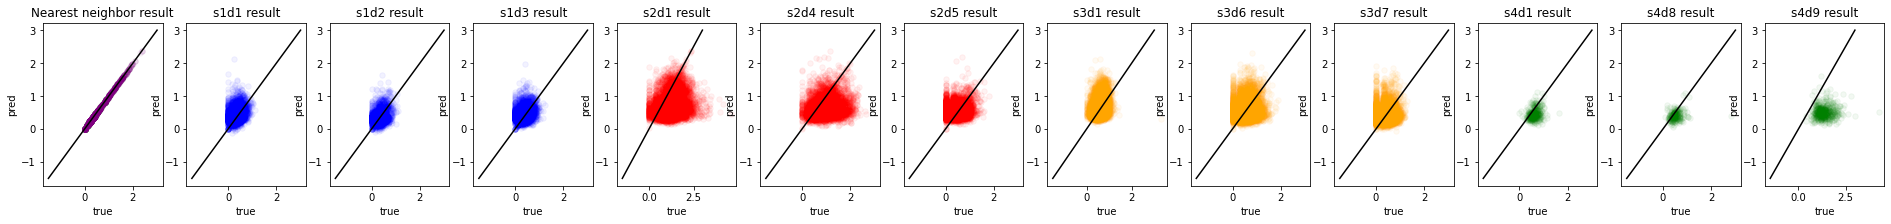

Epoch  23100 near loss: 0.0031385776 s1d1:  0.24420805 s1d2:  0.19981365 s1d3:  0.23534982 s2d1: 0.7311119 s2d4: 0.5671824 s2d5: 0.346163 s3d1: 0.29115456 s3d6: 0.37038475 s3d7: 0.31128344 s4d1: 0.26391172 s4d8: 0.2850862 s4d9: 0.94736356 test loss: 0.6723377863774408
Epoch  23200 near loss: 0.008520535 s1d1:  0.24244498 s1d2:  0.19879323 s1d3:  0.23366477 s2d1: 0.73544806 s2d4: 0.5703986 s2d5: 0.3432207 s3d1: 0.28969696 s3d6: 0.3691533 s3d7: 0.3095184 s4d1: 0.2664443 s4d8: 0.28649455 s4d9: 0.9534677 test loss: 0.6767415464243701
Epoch  23300 near loss: 0.004658278 s1d1:  0.24315475 s1d2:  0.19935857 s1d3:  0.23440365 s2d1: 0.7331953 s2d4: 0.5686027 s2d5: 0.34476694 s3d1: 0.29016623 s3d6: 0.36970568 s3d7: 0.31047282 s4d1: 0.26549366 s4d8: 0.28621516 s4d9: 0.95103633 test loss: 0.6750197369727589
Epoch  23400 near loss: 0.0036561152 s1d1:  0.24506706 s1d2:  0.20025551 s1d3:  0.23593466 s2d1: 0.72973174 s2d4: 0.5657842 s2d5: 0.3471515 s3d1: 0.29190168 s3d6: 0.3712534 s3d7: 0.31203595 s4d

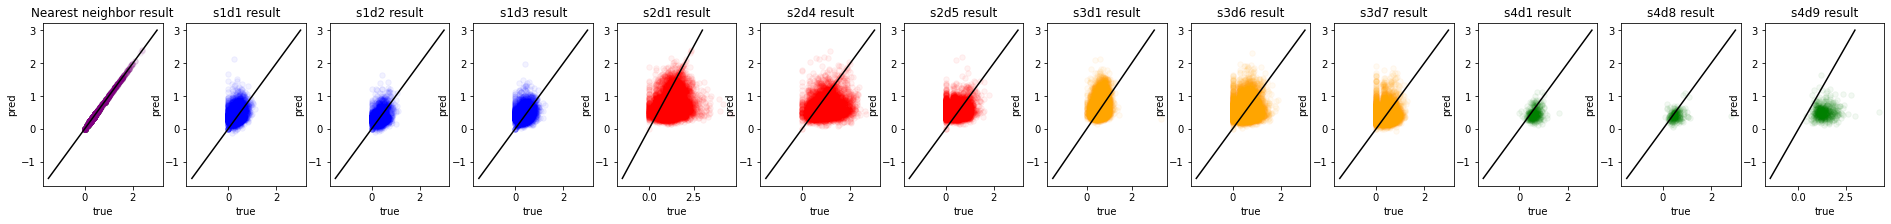

Epoch  24100 near loss: 0.002669919 s1d1:  0.2456045 s1d2:  0.20036337 s1d3:  0.23668152 s2d1: 0.729031 s2d4: 0.566351 s2d5: 0.3472817 s3d1: 0.2923468 s3d6: 0.37117377 s3d7: 0.31206852 s4d1: 0.26358753 s4d8: 0.28519624 s4d9: 0.94615287 test loss: 0.6715219527998095
Epoch  24200 near loss: 0.0031040283 s1d1:  0.24635696 s1d2:  0.20068498 s1d3:  0.23711643 s2d1: 0.7287925 s2d4: 0.5661378 s2d5: 0.3472997 s3d1: 0.29346287 s3d6: 0.3721773 s3d7: 0.3125182 s4d1: 0.26410562 s4d8: 0.28544867 s4d9: 0.94599813 test loss: 0.6715120829057792
Epoch  24300 near loss: 0.0056042424 s1d1:  0.24295498 s1d2:  0.19895722 s1d3:  0.23406751 s2d1: 0.7332465 s2d4: 0.56920516 s2d5: 0.34469235 s3d1: 0.290397 s3d6: 0.3699752 s3d7: 0.3100677 s4d1: 0.26582718 s4d8: 0.28654036 s4d9: 0.9510705 test loss: 0.6751142182285138
Epoch  24400 near loss: 0.0035490822 s1d1:  0.24605547 s1d2:  0.20066716 s1d3:  0.2369911 s2d1: 0.7290472 s2d4: 0.56625587 s2d5: 0.34730148 s3d1: 0.2919559 s3d6: 0.37092218 s3d7: 0.3121486 s4d1: 0.

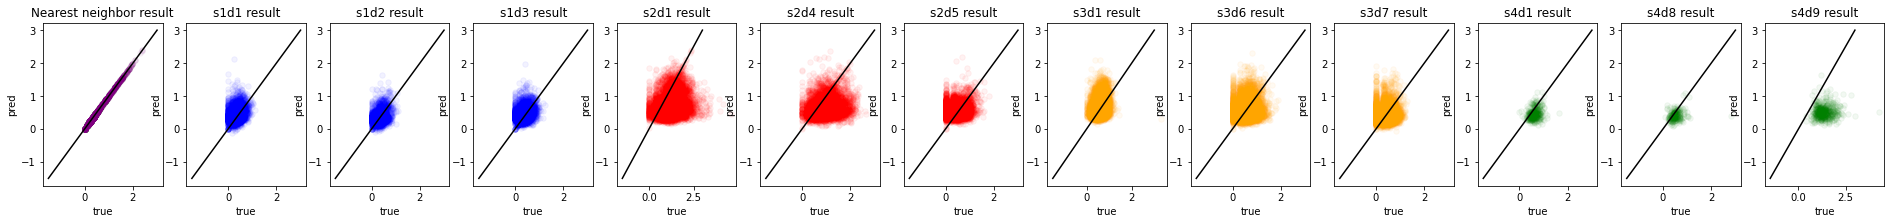

Epoch  25100 near loss: 0.0028107483 s1d1:  0.24402045 s1d2:  0.19967884 s1d3:  0.23536552 s2d1: 0.73105323 s2d4: 0.5680232 s2d5: 0.34616202 s3d1: 0.29117405 s3d6: 0.3706738 s3d7: 0.31095782 s4d1: 0.26511565 s4d8: 0.2862842 s4d9: 0.9488944 test loss: 0.6735910515409292
Epoch  25200 near loss: 0.0074356426 s1d1:  0.24310692 s1d2:  0.19911212 s1d3:  0.23436156 s2d1: 0.7338985 s2d4: 0.56924444 s2d5: 0.34405327 s3d1: 0.28957638 s3d6: 0.36936238 s3d7: 0.30974084 s4d1: 0.26578334 s4d8: 0.28607872 s4d9: 0.9511225 test loss: 0.6751015834398902
Epoch  25300 near loss: 0.002745091 s1d1:  0.24492393 s1d2:  0.19996735 s1d3:  0.23600623 s2d1: 0.73025966 s2d4: 0.56716275 s2d5: 0.34634885 s3d1: 0.29197747 s3d6: 0.37117332 s3d7: 0.3114123 s4d1: 0.26444098 s4d8: 0.28571048 s4d9: 0.9476147 test loss: 0.6726244982426184
Epoch  25400 near loss: 0.0025037907 s1d1:  0.24534442 s1d2:  0.20024586 s1d3:  0.23650558 s2d1: 0.73084694 s2d4: 0.56727046 s2d5: 0.34605107 s3d1: 0.29154927 s3d6: 0.37102756 s3d7: 0.311

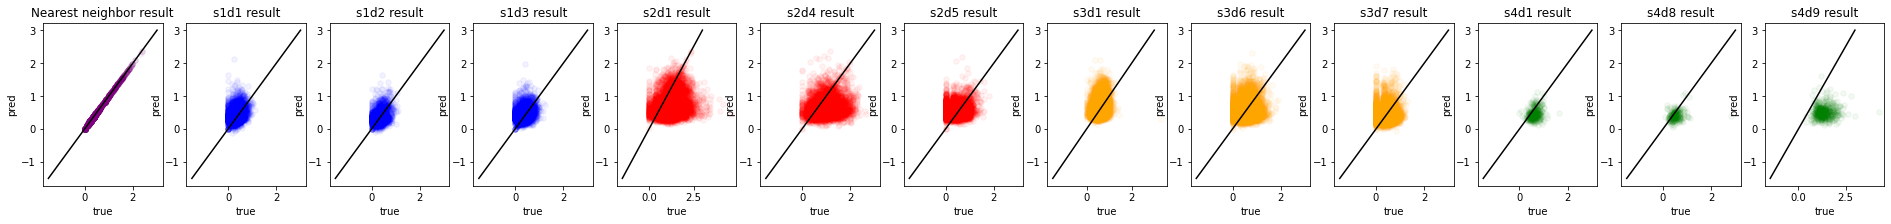

Epoch  26100 near loss: 0.004871351 s1d1:  0.24824993 s1d2:  0.20168646 s1d3:  0.23893948 s2d1: 0.72722507 s2d4: 0.5647171 s2d5: 0.34826043 s3d1: 0.2934719 s3d6: 0.37245846 s3d7: 0.31325117 s4d1: 0.26241025 s4d8: 0.28438494 s4d9: 0.94246656 test loss: 0.6689122978528272
Epoch  26200 near loss: 0.0065631014 s1d1:  0.24711294 s1d2:  0.20131677 s1d3:  0.238033 s2d1: 0.72637385 s2d4: 0.5641561 s2d5: 0.3491909 s3d1: 0.29341438 s3d6: 0.37257436 s3d7: 0.31348938 s4d1: 0.2628468 s4d8: 0.28509024 s4d9: 0.942276 test loss: 0.668908480433555
Epoch  26300 near loss: 0.00312553 s1d1:  0.24546807 s1d2:  0.20029375 s1d3:  0.2365623 s2d1: 0.72926694 s2d4: 0.5660923 s2d5: 0.34713927 s3d1: 0.29144096 s3d6: 0.37091398 s3d7: 0.3116561 s4d1: 0.26309457 s4d8: 0.28478175 s4d9: 0.9445222 test loss: 0.6703663122756083
Epoch  26400 near loss: 0.004275095 s1d1:  0.24420485 s1d2:  0.1994695 s1d3:  0.23533714 s2d1: 0.7326526 s2d4: 0.5688096 s2d5: 0.34478638 s3d1: 0.29086924 s3d6: 0.3704935 s3d7: 0.31030068 s4d1: 0

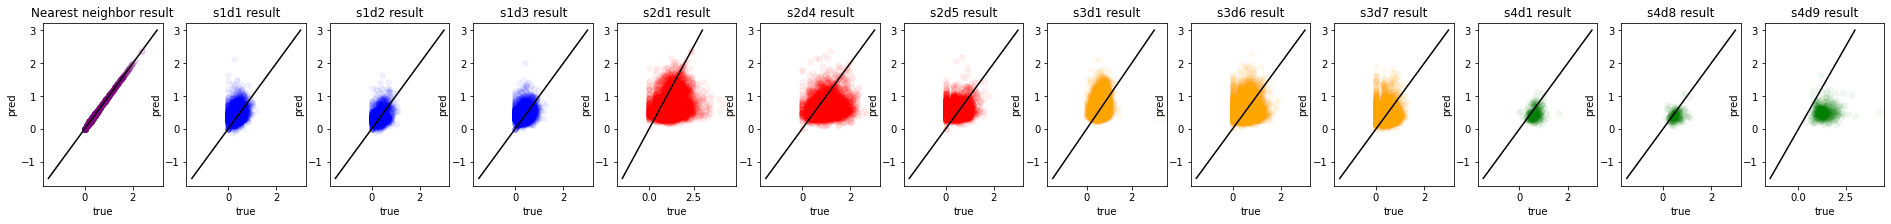

Epoch  27100 near loss: 0.002960549 s1d1:  0.2454537 s1d2:  0.2002577 s1d3:  0.23662698 s2d1: 0.7306279 s2d4: 0.56707674 s2d5: 0.34608385 s3d1: 0.2911531 s3d6: 0.37084773 s3d7: 0.31116098 s4d1: 0.26445055 s4d8: 0.28533113 s4d9: 0.94675374 test loss: 0.6720356563511465
Epoch  27200 near loss: 0.002802168 s1d1:  0.24680825 s1d2:  0.20080835 s1d3:  0.23770934 s2d1: 0.7284101 s2d4: 0.5657853 s2d5: 0.34748006 s3d1: 0.29196352 s3d6: 0.37156388 s3d7: 0.31216562 s4d1: 0.26374027 s4d8: 0.28520486 s4d9: 0.94442046 test loss: 0.670422479653782
Epoch  27300 near loss: 0.0038017728 s1d1:  0.2446478 s1d2:  0.19984484 s1d3:  0.23612337 s2d1: 0.7317483 s2d4: 0.5681319 s2d5: 0.34549987 s3d1: 0.29061547 s3d6: 0.37045604 s3d7: 0.31052122 s4d1: 0.26513597 s4d8: 0.28600413 s4d9: 0.94842756 test loss: 0.6732672610039149
Epoch  27400 near loss: 0.0026540137 s1d1:  0.24538837 s1d2:  0.20022333 s1d3:  0.23664457 s2d1: 0.7306034 s2d4: 0.5667944 s2d5: 0.34617457 s3d1: 0.29093745 s3d6: 0.37093028 s3d7: 0.31119537

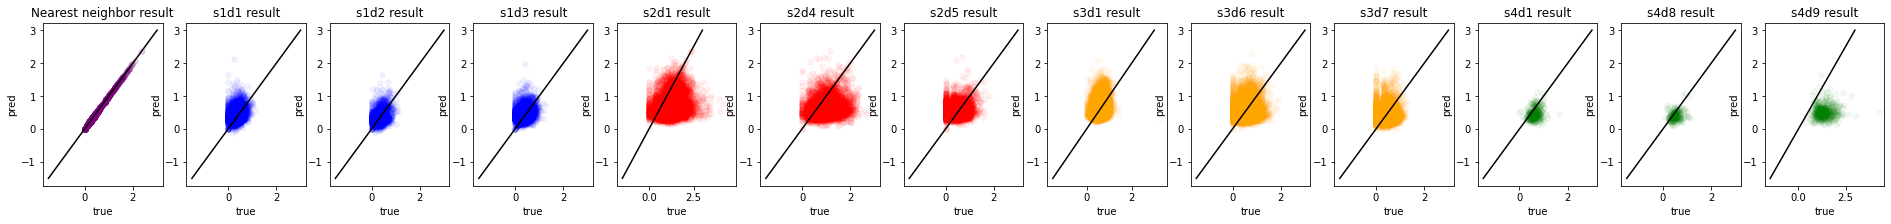

Epoch  28100 near loss: 0.0071966904 s1d1:  0.24358131 s1d2:  0.19934593 s1d3:  0.23515819 s2d1: 0.73373854 s2d4: 0.5696924 s2d5: 0.3439801 s3d1: 0.2898559 s3d6: 0.36978868 s3d7: 0.30982345 s4d1: 0.26648027 s4d8: 0.2867956 s4d9: 0.95136744 test loss: 0.6754146246068563
Epoch  28200 near loss: 0.0054274397 s1d1:  0.24424456 s1d2:  0.1996513 s1d3:  0.23562708 s2d1: 0.73258424 s2d4: 0.56873065 s2d5: 0.3448588 s3d1: 0.2901186 s3d6: 0.3701233 s3d7: 0.3101414 s4d1: 0.26553187 s4d8: 0.2859889 s4d9: 0.94935316 test loss: 0.6739164846730121
Epoch  28300 near loss: 0.0041855667 s1d1:  0.24502859 s1d2:  0.19992547 s1d3:  0.2363628 s2d1: 0.72981083 s2d4: 0.5670456 s2d5: 0.34634337 s3d1: 0.29075631 s3d6: 0.3704976 s3d7: 0.31101903 s4d1: 0.26437226 s4d8: 0.2857006 s4d9: 0.9465428 test loss: 0.6719214724559087
Epoch  28400 near loss: 0.005774131 s1d1:  0.24713875 s1d2:  0.20135647 s1d3:  0.2383918 s2d1: 0.7266767 s2d4: 0.564622 s2d5: 0.34909633 s3d1: 0.29249915 s3d6: 0.37225127 s3d7: 0.31283942 s4d1:

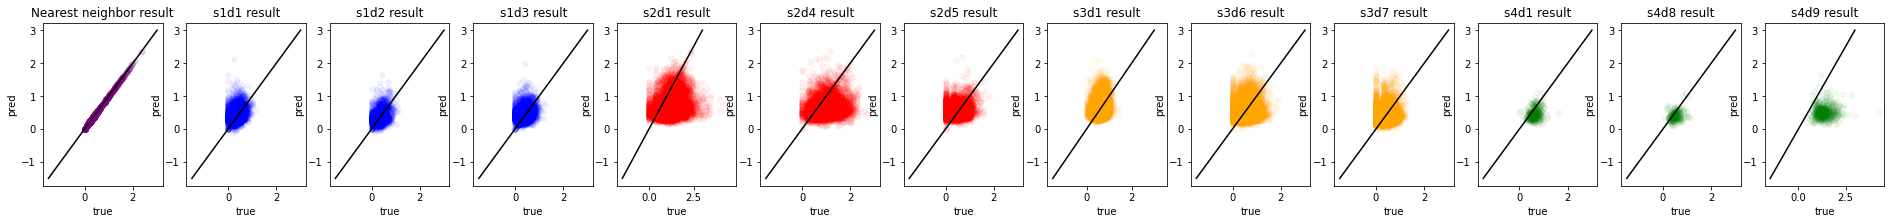

Epoch  29100 near loss: 0.003889423 s1d1:  0.24511778 s1d2:  0.20001574 s1d3:  0.23642687 s2d1: 0.73121995 s2d4: 0.5678608 s2d5: 0.34584343 s3d1: 0.2901041 s3d6: 0.3702772 s3d7: 0.31063762 s4d1: 0.26514077 s4d8: 0.2861849 s4d9: 0.9478137 test loss: 0.6728868805871817
Epoch  29200 near loss: 0.006324503 s1d1:  0.24459158 s1d2:  0.19969067 s1d3:  0.23576848 s2d1: 0.7327351 s2d4: 0.56946874 s2d5: 0.34462318 s3d1: 0.29043972 s3d6: 0.37046832 s3d7: 0.31007844 s4d1: 0.26628175 s4d8: 0.28660563 s4d9: 0.94988924 test loss: 0.6744160917877414
Epoch  29300 near loss: 0.0022585175 s1d1:  0.2461327 s1d2:  0.20059177 s1d3:  0.23733331 s2d1: 0.7290019 s2d4: 0.56681055 s2d5: 0.34713867 s3d1: 0.2916801 s3d6: 0.37127307 s3d7: 0.31165487 s4d1: 0.26412317 s4d8: 0.2854567 s4d9: 0.94535923 test loss: 0.6711019711940113
Epoch  29400 near loss: 0.0027442721 s1d1:  0.24545327 s1d2:  0.2001548 s1d3:  0.23674855 s2d1: 0.72954845 s2d4: 0.5669001 s2d5: 0.34685367 s3d1: 0.29089162 s3d6: 0.3709516 s3d7: 0.31116793 

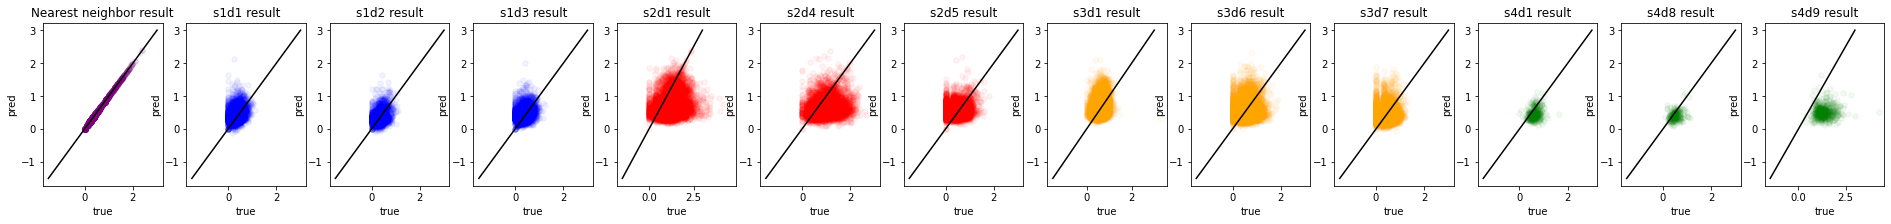

Epoch  30100 near loss: 0.00268928 s1d1:  0.24606618 s1d2:  0.20039012 s1d3:  0.23727328 s2d1: 0.72904617 s2d4: 0.5665364 s2d5: 0.3469071 s3d1: 0.2910429 s3d6: 0.37111938 s3d7: 0.31140572 s4d1: 0.26402062 s4d8: 0.28508043 s4d9: 0.9445481 test loss: 0.6705309048939458
Epoch  30200 near loss: 0.006606074 s1d1:  0.2442727 s1d2:  0.19942905 s1d3:  0.23558117 s2d1: 0.7324651 s2d4: 0.56906134 s2d5: 0.34456635 s3d1: 0.28988665 s3d6: 0.37012053 s3d7: 0.30981985 s4d1: 0.2660873 s4d8: 0.2863199 s4d9: 0.94956887 test loss: 0.6741581946470796
Epoch  30300 near loss: 0.0020884795 s1d1:  0.24637607 s1d2:  0.2006166 s1d3:  0.23770545 s2d1: 0.72858137 s2d4: 0.56626356 s2d5: 0.34722868 s3d1: 0.29117292 s3d6: 0.37122378 s3d7: 0.3116013 s4d1: 0.26427147 s4d8: 0.28538838 s4d9: 0.94479007 test loss: 0.6707474654353657
Epoch  30400 near loss: 0.0025113667 s1d1:  0.24579898 s1d2:  0.2004297 s1d3:  0.23743418 s2d1: 0.7276373 s2d4: 0.5657677 s2d5: 0.34829256 s3d1: 0.29107228 s3d6: 0.37119207 s3d7: 0.3116593 s4

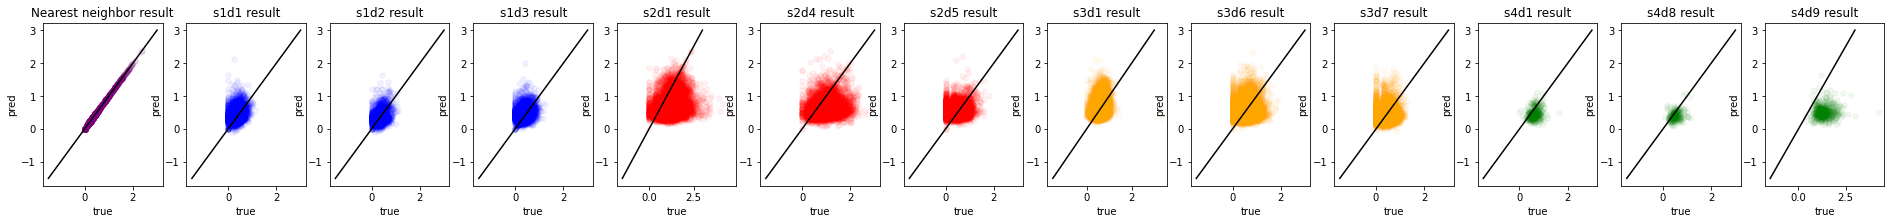

Epoch  31100 near loss: 0.0030652068 s1d1:  0.2452595 s1d2:  0.20009938 s1d3:  0.23691073 s2d1: 0.7287291 s2d4: 0.5670867 s2d5: 0.34738797 s3d1: 0.29110405 s3d6: 0.37090752 s3d7: 0.31109968 s4d1: 0.26501697 s4d8: 0.28579587 s4d9: 0.94591707 test loss: 0.6716101544210614
Epoch  31200 near loss: 0.0045832605 s1d1:  0.24538651 s1d2:  0.20015353 s1d3:  0.2368524 s2d1: 0.73024994 s2d4: 0.56745964 s2d5: 0.34630328 s3d1: 0.29024526 s3d6: 0.3705701 s3d7: 0.310684 s4d1: 0.2654191 s4d8: 0.285893 s4d9: 0.94667417 test loss: 0.6721611480167309
Epoch  31300 near loss: 0.006013425 s1d1:  0.24490243 s1d2:  0.1998222 s1d3:  0.2366033 s2d1: 0.7310901 s2d4: 0.56804 s2d5: 0.34544078 s3d1: 0.29007944 s3d6: 0.37017247 s3d7: 0.31043148 s4d1: 0.26545268 s4d8: 0.28585503 s4d9: 0.9481256 test loss: 0.6731006014828664
Epoch  31400 near loss: 0.004276933 s1d1:  0.24730761 s1d2:  0.201111 s1d3:  0.23855 s2d1: 0.72649366 s2d4: 0.5647167 s2d5: 0.34883547 s3d1: 0.2919719 s3d6: 0.37206292 s3d7: 0.31243896 s4d1: 0.263

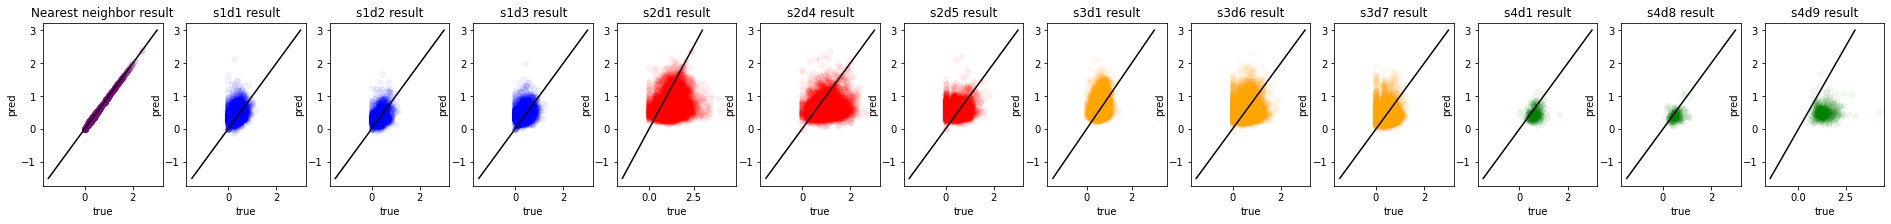

Epoch  32100 near loss: 0.0024110798 s1d1:  0.24639551 s1d2:  0.20047061 s1d3:  0.23762093 s2d1: 0.72957575 s2d4: 0.56671786 s2d5: 0.34646633 s3d1: 0.29078895 s3d6: 0.3710594 s3d7: 0.3111281 s4d1: 0.2644113 s4d8: 0.28540388 s4d9: 0.94484687 test loss: 0.6708039628799076
Epoch  32200 near loss: 0.0028466168 s1d1:  0.24749303 s1d2:  0.20115978 s1d3:  0.23874643 s2d1: 0.7275183 s2d4: 0.56534356 s2d5: 0.3478161 s3d1: 0.2910251 s3d6: 0.37139252 s3d7: 0.31180322 s4d1: 0.26346743 s4d8: 0.28466803 s4d9: 0.9422704 test loss: 0.6689491894073634
Epoch  32300 near loss: 0.0049464577 s1d1:  0.24489756 s1d2:  0.199788 s1d3:  0.2362779 s2d1: 0.73116404 s2d4: 0.56842464 s2d5: 0.34535238 s3d1: 0.28975084 s3d6: 0.37013024 s3d7: 0.31030008 s4d1: 0.26572767 s4d8: 0.286331 s4d9: 0.94817233 test loss: 0.6732089107867307
Epoch  32400 near loss: 0.0030439831 s1d1:  0.24731952 s1d2:  0.20085089 s1d3:  0.23838866 s2d1: 0.7290385 s2d4: 0.5670182 s2d5: 0.3466924 s3d1: 0.29139364 s3d6: 0.37157628 s3d7: 0.31145298 

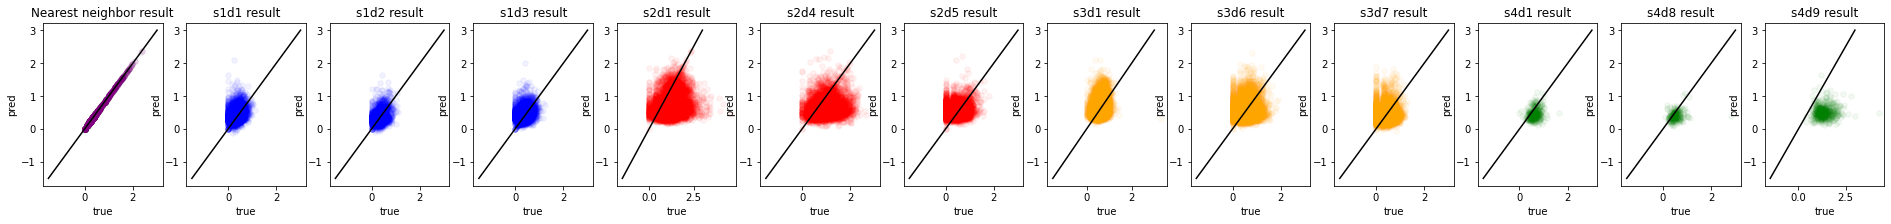

Epoch  33100 near loss: 0.0052868063 s1d1:  0.2449151 s1d2:  0.1997461 s1d3:  0.23650326 s2d1: 0.7309612 s2d4: 0.5681599 s2d5: 0.3454655 s3d1: 0.2895523 s3d6: 0.37006342 s3d7: 0.3101437 s4d1: 0.26533332 s4d8: 0.28616828 s4d9: 0.9472561 test loss: 0.6725502867758252
Epoch  33200 near loss: 0.0039329166 s1d1:  0.24586652 s1d2:  0.20017564 s1d3:  0.23734565 s2d1: 0.7298431 s2d4: 0.56753105 s2d5: 0.3461729 s3d1: 0.29018414 s3d6: 0.37069592 s3d7: 0.3107713 s4d1: 0.2653659 s4d8: 0.28582197 s4d9: 0.94645554 test loss: 0.6720065434896009
Epoch  33300 near loss: 0.0026579762 s1d1:  0.24759647 s1d2:  0.20117275 s1d3:  0.23901297 s2d1: 0.7270761 s2d4: 0.5659679 s2d5: 0.34822503 s3d1: 0.2918376 s3d6: 0.37194914 s3d7: 0.31216833 s4d1: 0.26445654 s4d8: 0.28575048 s4d9: 0.943634 test loss: 0.6700563888686989
Epoch  33400 near loss: 0.0019372797 s1d1:  0.24600528 s1d2:  0.20038007 s1d3:  0.2375172 s2d1: 0.7285796 s2d4: 0.56668454 s2d5: 0.3473902 s3d1: 0.290528 s3d6: 0.37104127 s3d7: 0.31110597 s4d1: 0

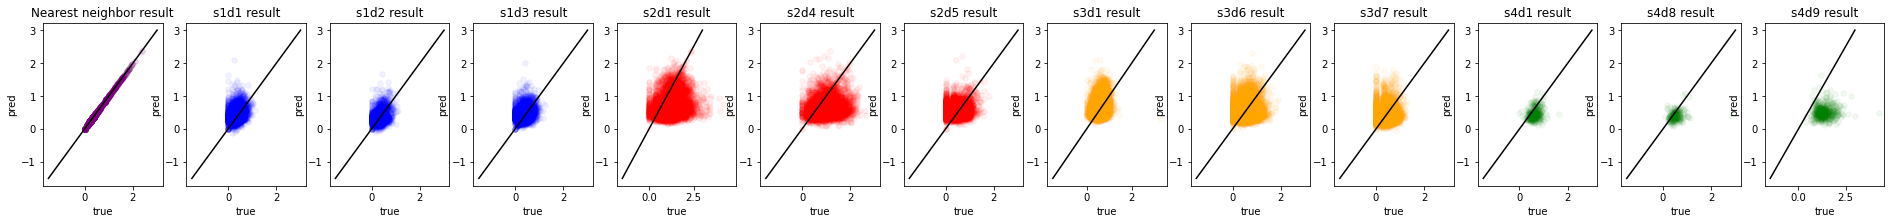

Epoch  34100 near loss: 0.002265425 s1d1:  0.24621896 s1d2:  0.20060943 s1d3:  0.23781939 s2d1: 0.7276036 s2d4: 0.566194 s2d5: 0.34791762 s3d1: 0.29058835 s3d6: 0.37110177 s3d7: 0.311329 s4d1: 0.26432514 s4d8: 0.28557447 s4d9: 0.9437593 test loss: 0.6701045861722963
Epoch  34200 near loss: 0.004059585 s1d1:  0.24439564 s1d2:  0.19972657 s1d3:  0.23635343 s2d1: 0.7306596 s2d4: 0.56791925 s2d5: 0.34633628 s3d1: 0.28867114 s3d6: 0.3698889 s3d7: 0.30987403 s4d1: 0.26562646 s4d8: 0.28648052 s4d9: 0.9467782 test loss: 0.6723075331692588
Epoch  34300 near loss: 0.0018749001 s1d1:  0.24686563 s1d2:  0.20087226 s1d3:  0.23850814 s2d1: 0.7278619 s2d4: 0.56631845 s2d5: 0.347682 s3d1: 0.290681 s3d6: 0.371395 s3d7: 0.31130207 s4d1: 0.26469246 s4d8: 0.2858225 s4d9: 0.9439067 test loss: 0.670270172813482
Epoch  34400 near loss: 0.005765955 s1d1:  0.24509448 s1d2:  0.19971472 s1d3:  0.23667446 s2d1: 0.7312245 s2d4: 0.56874245 s2d5: 0.34499452 s3d1: 0.28972968 s3d6: 0.37023067 s3d7: 0.30999175 s4d1: 0.

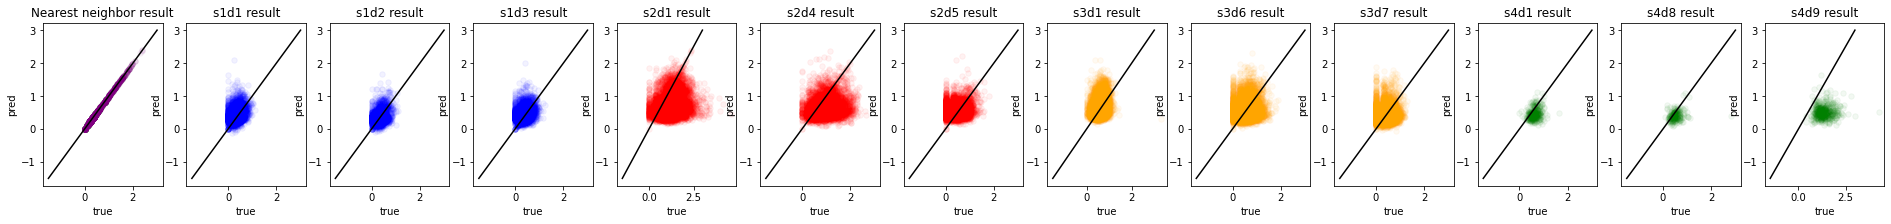

Epoch  35100 near loss: 0.0027950453 s1d1:  0.2473788 s1d2:  0.20105225 s1d3:  0.23877181 s2d1: 0.726769 s2d4: 0.56554383 s2d5: 0.3482709 s3d1: 0.29088172 s3d6: 0.3713419 s3d7: 0.31177637 s4d1: 0.26369622 s4d8: 0.28507578 s4d9: 0.9421004 test loss: 0.6689053278479828
Epoch  35200 near loss: 0.0036236304 s1d1:  0.24833256 s1d2:  0.20129772 s1d3:  0.23950572 s2d1: 0.72614604 s2d4: 0.5651634 s2d5: 0.34821993 s3d1: 0.29123336 s3d6: 0.37162685 s3d7: 0.3120267 s4d1: 0.26300263 s4d8: 0.28467605 s4d9: 0.94152915 test loss: 0.6684095331039869
Epoch  35300 near loss: 0.0027979969 s1d1:  0.24621883 s1d2:  0.2004527 s1d3:  0.23760943 s2d1: 0.7281922 s2d4: 0.56622666 s2d5: 0.34729162 s3d1: 0.2897094 s3d6: 0.37055242 s3d7: 0.31105307 s4d1: 0.26428485 s4d8: 0.2854432 s4d9: 0.94359076 test loss: 0.6699787199465016
Epoch  35400 near loss: 0.0019757403 s1d1:  0.24726184 s1d2:  0.20095342 s1d3:  0.23857585 s2d1: 0.7279484 s2d4: 0.56605554 s2d5: 0.34736174 s3d1: 0.29081878 s3d6: 0.3713136 s3d7: 0.3116185 

KeyboardInterrupt: 

In [41]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)